#### Instalando Pacotes e Bibliotecas

In [ ]:
pip install requests

In [ ]:
pip install pandas

In [ ]:
pip install pandas pyarrow

In [ ]:
pip install matplotlib

#### Imports necessários

In [21]:
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#### CMD para definir as datas

In [3]:
today = datetime.today()

if today.weekday() == 5:   
    today -= timedelta(days = 1)
    
elif today.weekday() == 6:    
    today -= timedelta(days = 2)

ten_days_before = today
i = 0

while i != 9:
    if ten_days_before.weekday() < 5:
        i += 1

    ten_days_before -= timedelta(days = 1)

#### Conexão com a API e Absorção dos Dados (.json)

In [6]:
API_KEY = "19HYD6hzI86Hqfx8sTvN4fzh0wrBb4oyPlORREtn"

ENDPOINT = "https://api.stockdata.org/v1/data/intraday"

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "ORCL", "INTC", "ADBE"]

for i in tickers:
    params = {
        "symbols": i,
        "interval": "hour",
        "api_token": API_KEY,
        "date_from": ten_days_before.strftime('%Y-%m-%d'),
        "date_to": today.strftime('%Y-%m-%d')
    }

    response = requests.get(ENDPOINT, params=params)

    if response.status_code == 200:
        
        data = response.json()

        caminho = "bronze/stock_data_bronze"+i+".json"

        with open(caminho, "w", encoding="utf-8") as arquivo:
            json.dump(data, arquivo, indent=4) 

    else:
        print(f"Erro: {response.status_code}, {response.text}")

#### Limpeza e transformação dos dados (.parquet)

In [15]:
for i in tickers:
    with open("bronze/stock_data_bronze"+i+".json", "r") as file:
        data = json.load(file)
        df = pd.json_normalize(data["data"])

        if tickers.index(i) > 0:
            df_final = pd.concat([df_final, df])
        else:
            df_final = df
        

df_final.to_parquet("silver/stock_data_silver.parquet", engine="pyarrow", index=False)

#### Análise dos Dados

In [16]:
df = pd.read_parquet("silver/stock_data_silver.parquet", engine="pyarrow")

df[["dia", "hora"]] = df['date'].str.split('T',expand=True)

df = df.groupby(["ticker", "dia"]).agg(preco_max=("data.close", "first"), preco_min=("data.open", "last")).reset_index()

df["preco"] = (df["preco_max"] + df["preco_min"])/2

df = df.rename(columns={"ticker": "codigo_acao"})[["codigo_acao", "dia", "preco"]]

df['dia'] = pd.to_datetime(df['dia'])

In [17]:
df.to_parquet("gold/stock_data_gold.parquet", engine="pyarrow", index=False)

In [18]:
display(df)

,codigo_acao,dia,preco
0,AAPL,2024-12-03,241.235
1,AAPL,2024-12-04,242.930
2,AAPL,2024-12-05,243.530
3,AAPL,2024-12-06,242.785
4,AAPL,2024-12-09,244.380
...,...,...,...
85,TSLA,2024-12-09,393.945
86,TSLA,2024-12-10,396.780
87,TSLA,2024-12-11,417.165
88,TSLA,2024-12-12,421.515


#### Gerando o Gráfico de Evolução

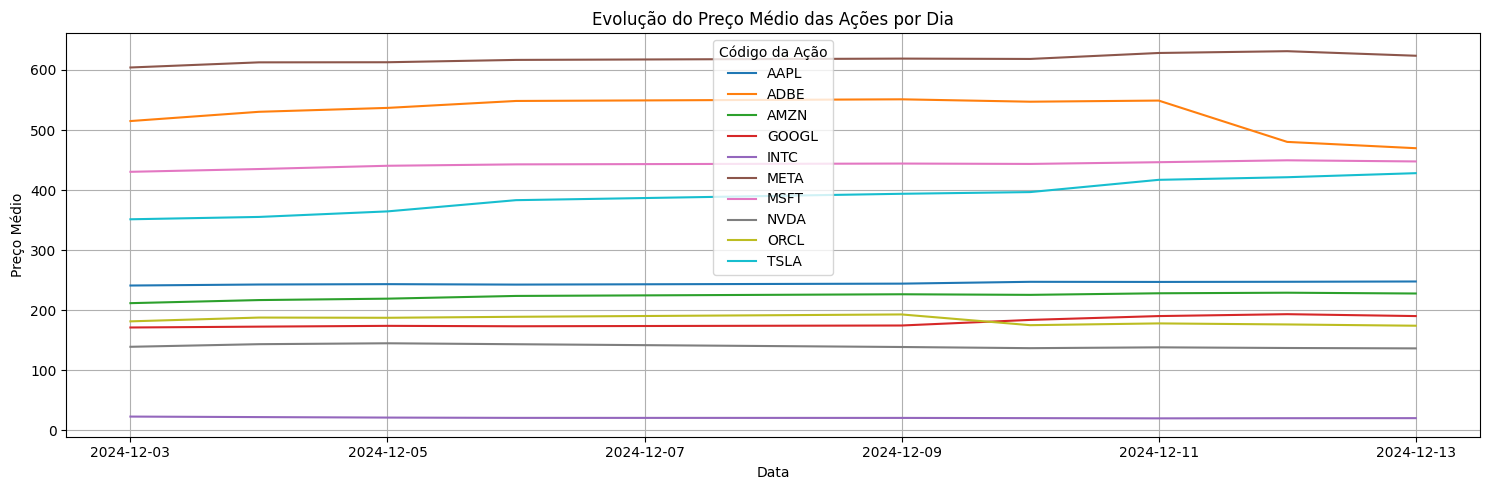

In [33]:
plt.figure(figsize=(15, 5))

for acao in df['codigo_acao'].unique():
    df_acao = df[df['codigo_acao'] == acao]
    plt.plot(df_acao['dia'], df_acao['preco'], label=acao)

plt.title('Evolução do Preço Médio das Ações por Dia')
plt.xlabel('Data')
plt.ylabel('Preço Médio')
plt.legend(title="Código da Ação")
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()


plt.show()